In [1]:
import utils
import models
import executor
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import pandas as pd
from utils import perfect_square_acc

In [2]:
# load your data here. The following ensure this will work on Windows as well as Unix
# the data file has its Kodaira symbols already preprocessed 
path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_kodaira_processed.parquet"
df = utils.load_data(path)

# process kodaira symbol if it is not already done
# path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000.parquet"
# df = utils.load_data(path)
# df = utils.process_kodaira_symbol(df)
# df.drop('lmfdb_label', axis=1, inplace=True)
# df.to_parquet(Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_kodaira_processed.parquet")

Loaded the dataset with 118 features and 3064705 curves..


In [4]:
# to get a balanced dataset with equal amount of 1 and 4 labels
len_4 = df[df['sha'] == 4].shape[0]
# df_balanced = df[df['sha'] == 1].sample(len_4) 
df_balanced = df[df['sha'] == 1].iloc[:len_4]
df_balanced = pd.concat([df_balanced, df[df['sha'] == 4]])
df_balanced.sha.value_counts()

1    158758
4    158758
Name: sha, dtype: int64

In [5]:
# choose model parameters
hidden_units = [128,64,32]

# default model parameters
input_dim, output_dim = utils.get_input_output_dim(df_balanced, 'sha', if_regression=True)

# check if we have cuda available
device = utils.get_device()

# create model
model = models.VanillaNN(input_dim, hidden_units, output_dim, if_dropout=False, dropout_rate=0.5, if_batchnorm=True).to(device)
# model = models.VanillaNN(input_dim, hidden_units, output_dim).to(device)

# print model summary
utils.model_summary(model)

The input dimension is 118 and the output dimension is 1.
Device: cpu.
The model has 26,049 trainable parameters..
VanillaNN(
  (layers): ModuleList(
    (0): Linear(in_features=118, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [6]:
# choose training parameters
loss_func = nn.MSELoss()
num_epochs = 3
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
evaluator = perfect_square_acc

Epoch 1/3, Training perfect_square_acc: 0.9397193833362203, Validation perfect_square_acc: 0.9395934050359825
Epoch 2/3, Training perfect_square_acc: 0.9604953046837682, Validation perfect_square_acc: 0.9605372974505142
Epoch 3/3, Training perfect_square_acc: 0.9697967025179913, Validation perfect_square_acc: 0.9698439443805804
Save the model from epoch 2 with perfect_square_acc 0.9698439443805804 to ..\trained_models\model.pth


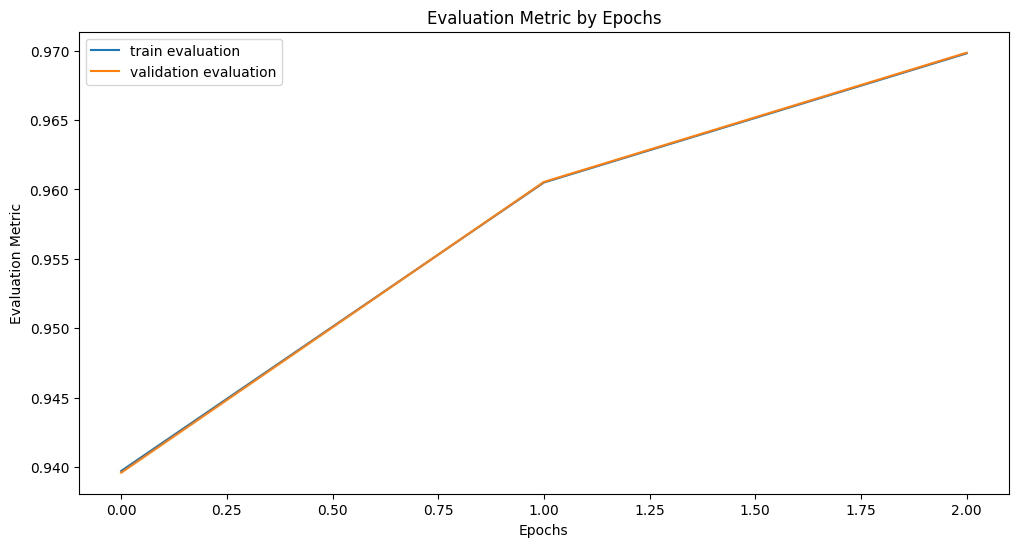

In [7]:
# split data
train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_balanced, 'sha', device, if_regression=True)
# train the model
model, train_eval_hist, val_eval_hist = executor.train(model, train_dataloader, val_dataset, loss_func, evaluator, optimizer, num_epochs, if_regression=True, verbose=True)
# plot train_eval_hist, val_eval_hist
utils.plot_train_eval_hist(train_eval_hist, val_eval_hist)

In [12]:
executor.test(model, test_dataset, evaluator, if_regression = True)

0.969702695893172